In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import sys 
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob

sys.path.append('../../src')

In [3]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography

In [22]:
# # plt.rcParams['figure.figsize'] = [6, 6]
# # plt.rcParams['figure.dpi'] = 120

adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')

In [23]:
adata

AnnData object with n_obs × n_vars = 23409 × 3311
    obs: 'cell_type', 'cell_type_int', 'seurat_clusters', 'umap_1', 'umap_2', 'author_cell_type'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

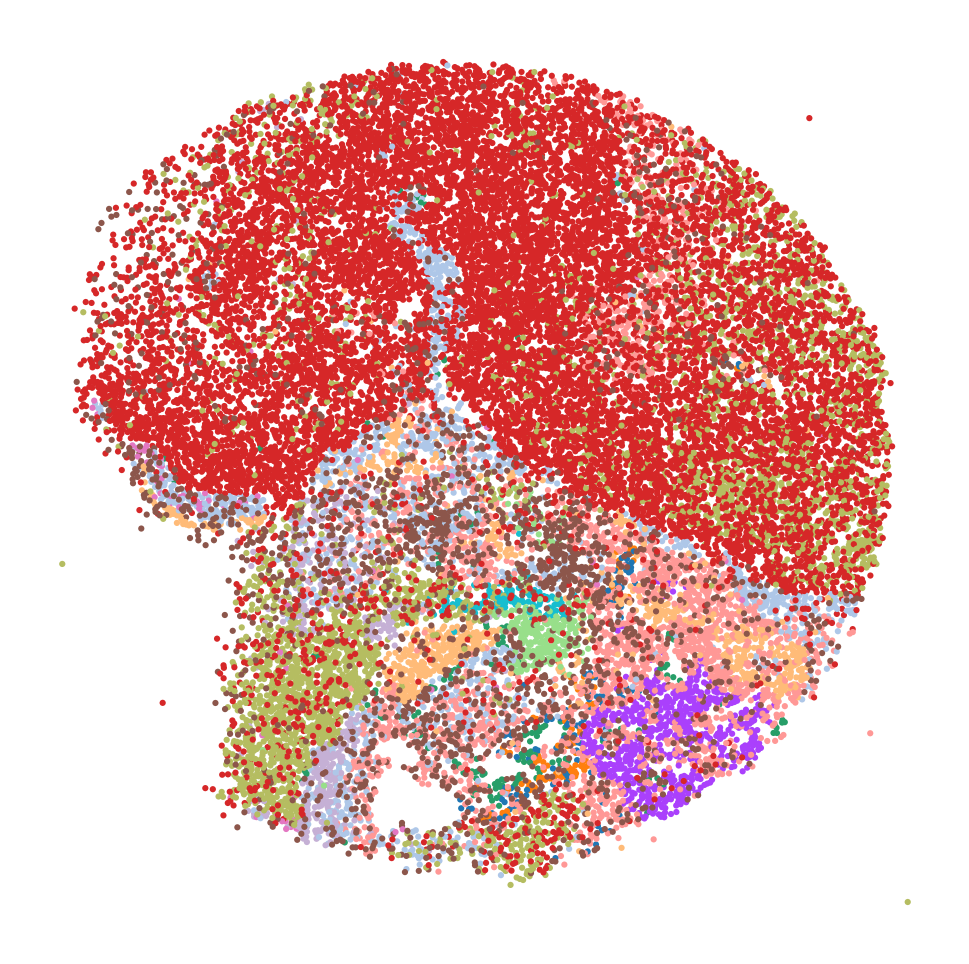

In [24]:
plt.rcParams['figure.figsize'] = [6, 6]
sc.pl.embedding(adata, color=['cell_type'], frameon=False, basis='spatial', 
        s=20, title=[''], legend_loc=None,
        # groups=['Brain', 'Heart', 'Mesenchyme', 'Preplacodal ectoderm', 'Preplacodal ectoderm']
        )

In [25]:
xy = xy_from_adata(adata)

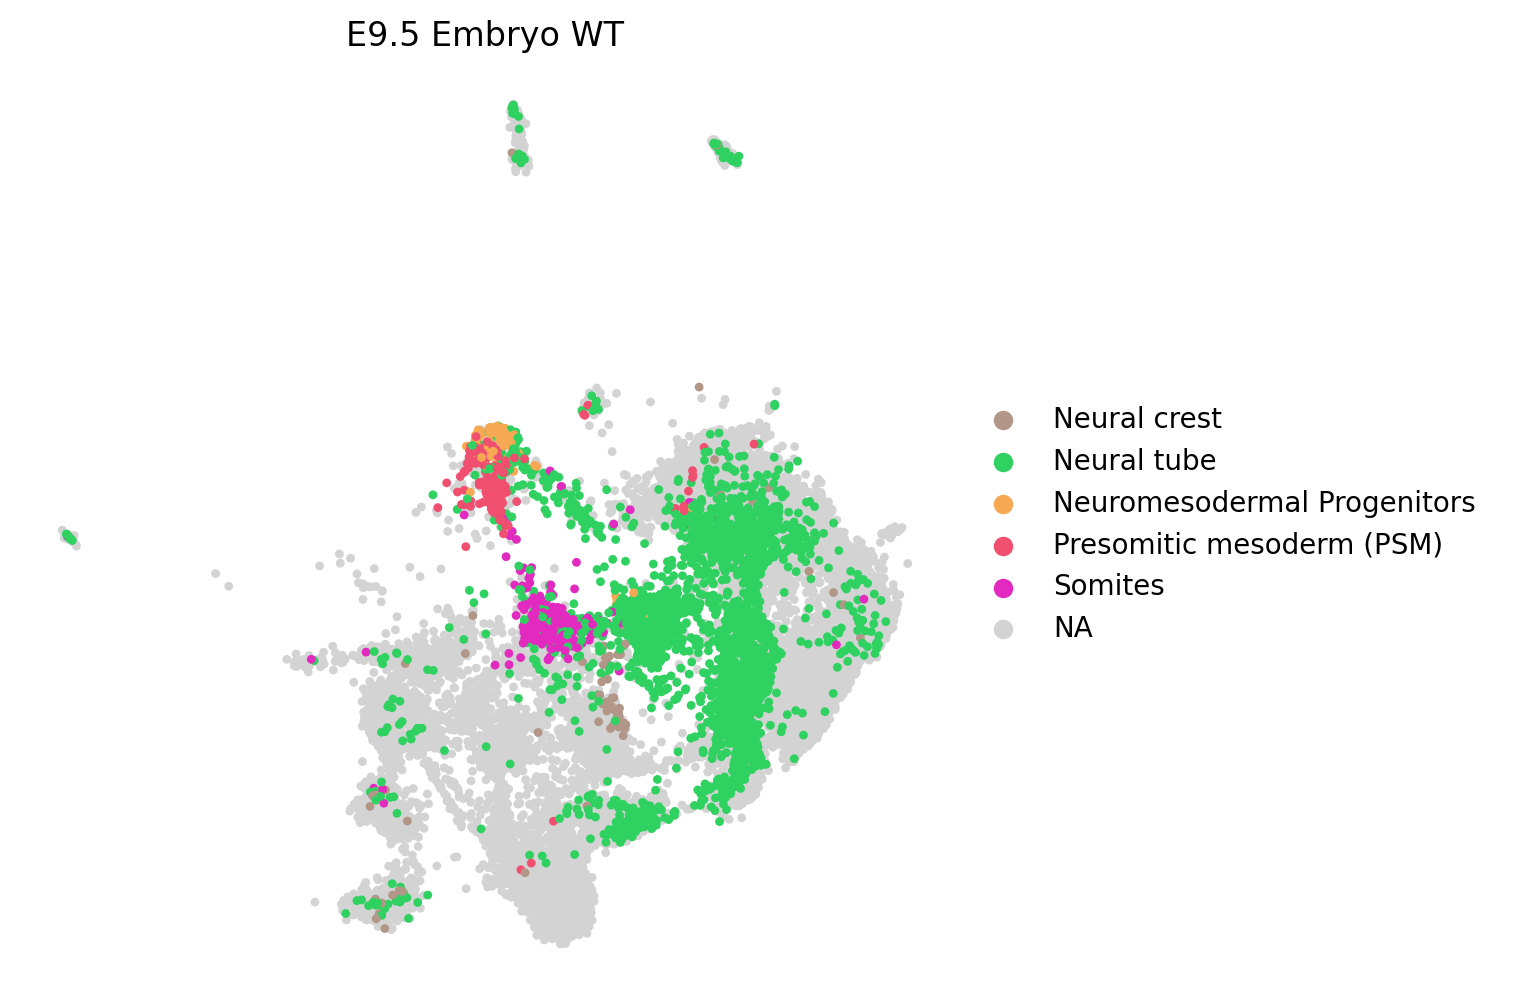

In [26]:

sc.pl.embedding(adata, color=['cell_type'], frameon=False, basis='umap', s=40, 
        groups=['Somites', 'Presomitic mesoderm (PSM)', 'Neural crest', 'Neural tube', 'Neuromesodermal Progenitors '], 
        add_outline=False,
        title=['E9.5 Embryo WT'],
                palette = {
                    'Ectopic tube': "#1af8e6",
                    'Neural tube': "#2fd160",
                    'Neural plate': "#e3f637",
                    'Neural crest': "#b29789",
                    'Somites': "#e22ac0",
                    'Presomitic mesoderm (PSM)': "#f14f70", 
                    'Neuromesodermal Progenitors ': "#f6a952",
                    'Amnion mesoderm early': 'lightgray',
                    'Amnion mesoderm late': 'lightgray',
                    'Angioblasts': 'lightgray',
                    'Brain': 'lightgray',
                    'Heart': 'lightgray',
                    'Mesenchyme': 'lightgray',
                    'Pharyngeal arch': 'lightgray',
                    'Preplacodal ectoderm': 'lightgray',
                    'Secondary heart field (SHF)': 'lightgray'
                })

In [27]:
import warnings
warnings.filterwarnings('ignore')

wtko = sc.read_h5ad('/Users/koush/Downloads/mouse_trunkTbx6WT_KO.h5ad')
wtko.var_names = wtko.var['feature_name']
wt = wtko[wtko.obs['orig.ident'] == '200703_25']
ko = wtko[wtko.obs['orig.ident'] == '200808_21']
del wt.raw
del ko.raw
wt.obsm['X_umap'] = wt.obs[['umap_1', 'umap_2']].values
ko.obsm['X_umap'] = ko.obs[['umap_1', 'umap_2']].values

ko.obs['cell_type'] = ko.obs[['seurat_clusters']].replace(
    {
        '5': 'Neural plate', 
        '4': 'Neural crest', 
        '3': 'Central tube', 
        '2': 'Ectopic tube',
        '0': 'Central tube',
        
    }
)
ko.obs['cell_type'].value_counts()

cell_type
Central tube    154
Ectopic tube    108
Neural crest     29
Neural plate     15
1                 3
Name: count, dtype: int64

In [28]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')
adata.X = adata.layers['imputed_count'].copy()
dfko = pd.read_parquet('/Users/koush/Downloads/Tbx6_4n_0x.parquet')
# dfko = pd.read_parquet('/Users/koush/Downloads/Sox2_4n_1x.parquet')
adata = adata[dfko.index]
adata = adata.concatenate(ko)

In [29]:
adata.shape

(6868, 2887)

In [30]:
color_dict = {
    'Ectopic tube': "#1af8e6",
    'Neural tube': "#2fd160",
    'Neural plate': "#e3f637",
    'Neural crest': "#b29789",
    'Somites': "#e22ac0",
    'Presomitic mesoderm (PSM)': "#f14f70", 
    'Neuromesodermal Progenitors ': "#f6a952",
}

In [32]:
del adata.uns
xy = xy_from_adata(adata)
og_obs = adata.obs.copy()
dfko = pd.concat([dfko, ko.to_df()], axis=0).dropna(axis=1)
adata.obs.index = dfko.index
adata.layers['imputed_count'] = adata.X.toarray()
adata = adata[adata.obs.cell_type.isin(color_dict.keys())]

In [14]:
chart = Cartography(adata, color_dict)

In [15]:
umap_coords = adata.obsm['X_umap']

dfko = dfko.loc[pd.DataFrame(umap_coords, columns=['UMAP1', 'UMAP2'], index=adata.obs_names).query(
    'UMAP1 > -3 and UMAP2 > -2 and UMAP2 < 9').index]
chart.adata = chart.adata[chart.adata.obs_names.isin(dfko.index)]

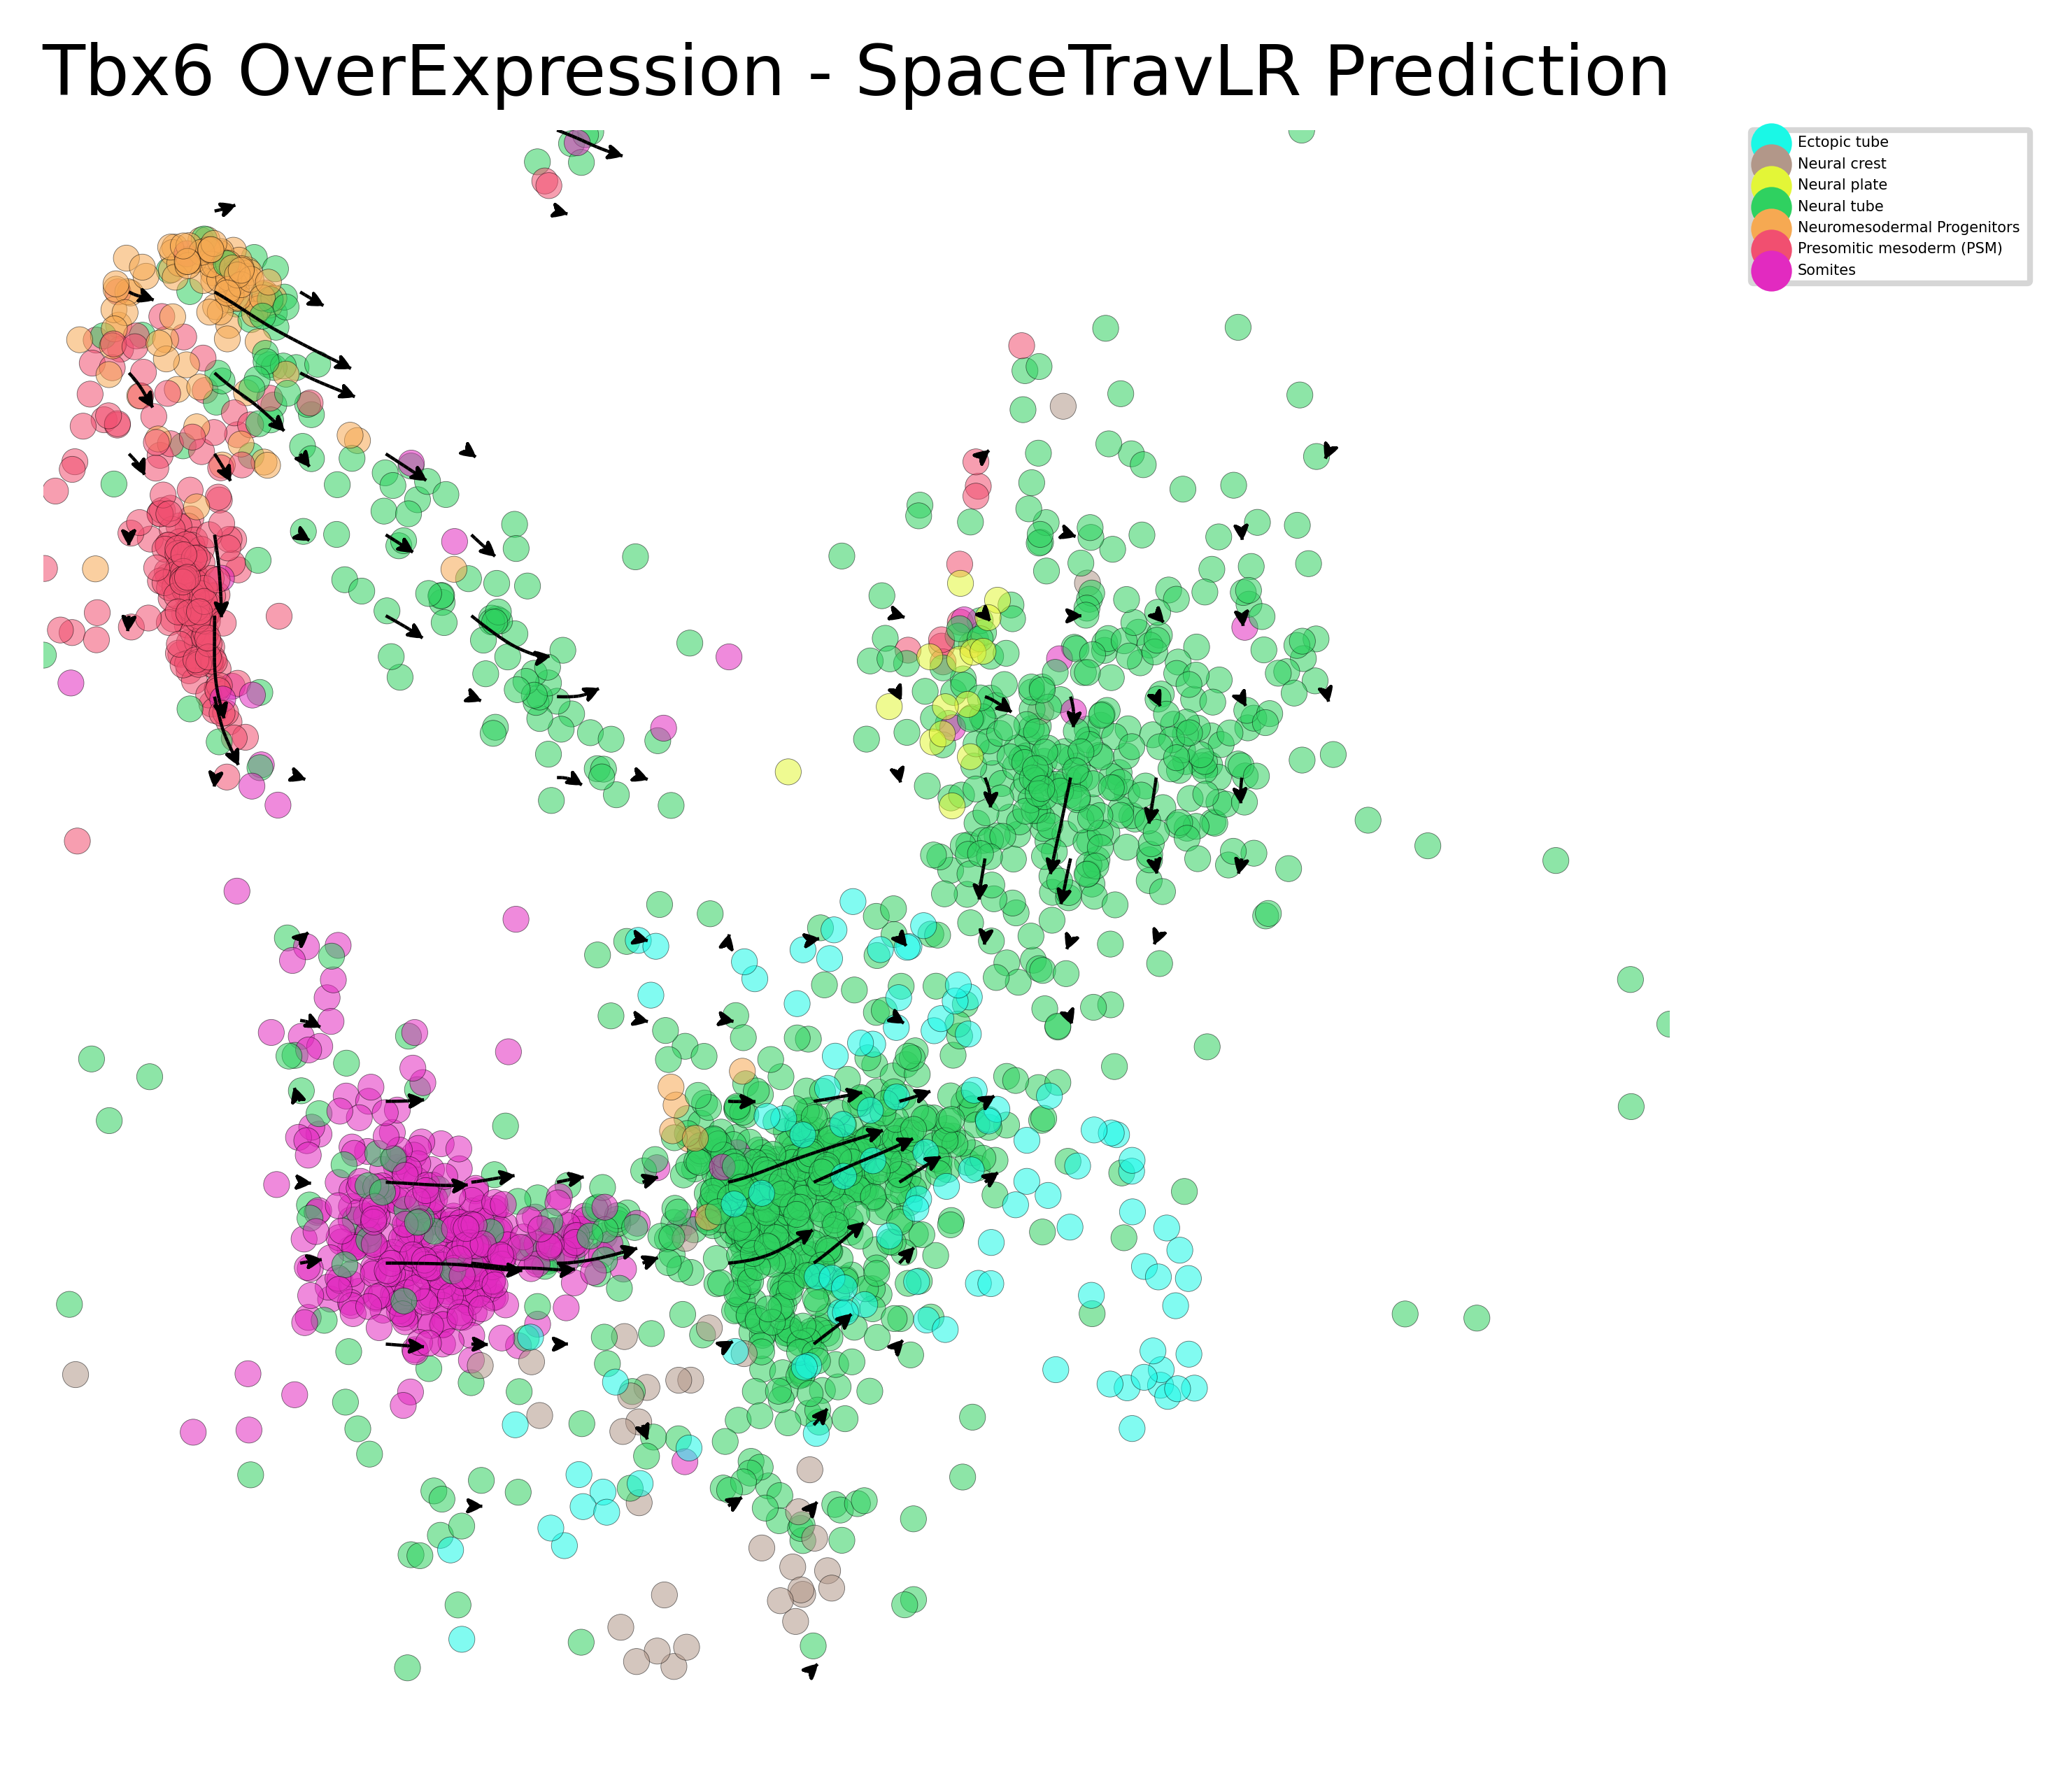

In [19]:
kotarget = 'Tbx6'
ax = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=1,
    vector_scale=0.9,
    figsize=(5, 5), 
    hue='cell_type',
    alpha=0.55,
    n_neighbors=500,
    scatter_size=20,
    # legend_on_loc=False,
    remove_null=True,
    normalize=False,
    perturbed_df=dfko.loc[chart.adata.obs_names],
    legend_fontsize=2.5,
    highlight_clusters=color_dict.keys()
)

    
# leg = plt.legend(bbox_to_anchor=(0.6, -0.1), loc='lower left', 
#     borderaxespad=0., markerscale=1.2, 
#     fontsize=5.5, frameon=False, ncols=1)

# for lh in leg.legend_handles:
#     lh.set_alpha(1)
    
plt.title(f'{kotarget} OverExpression - SpaceTravLR Prediction')
plt.show()

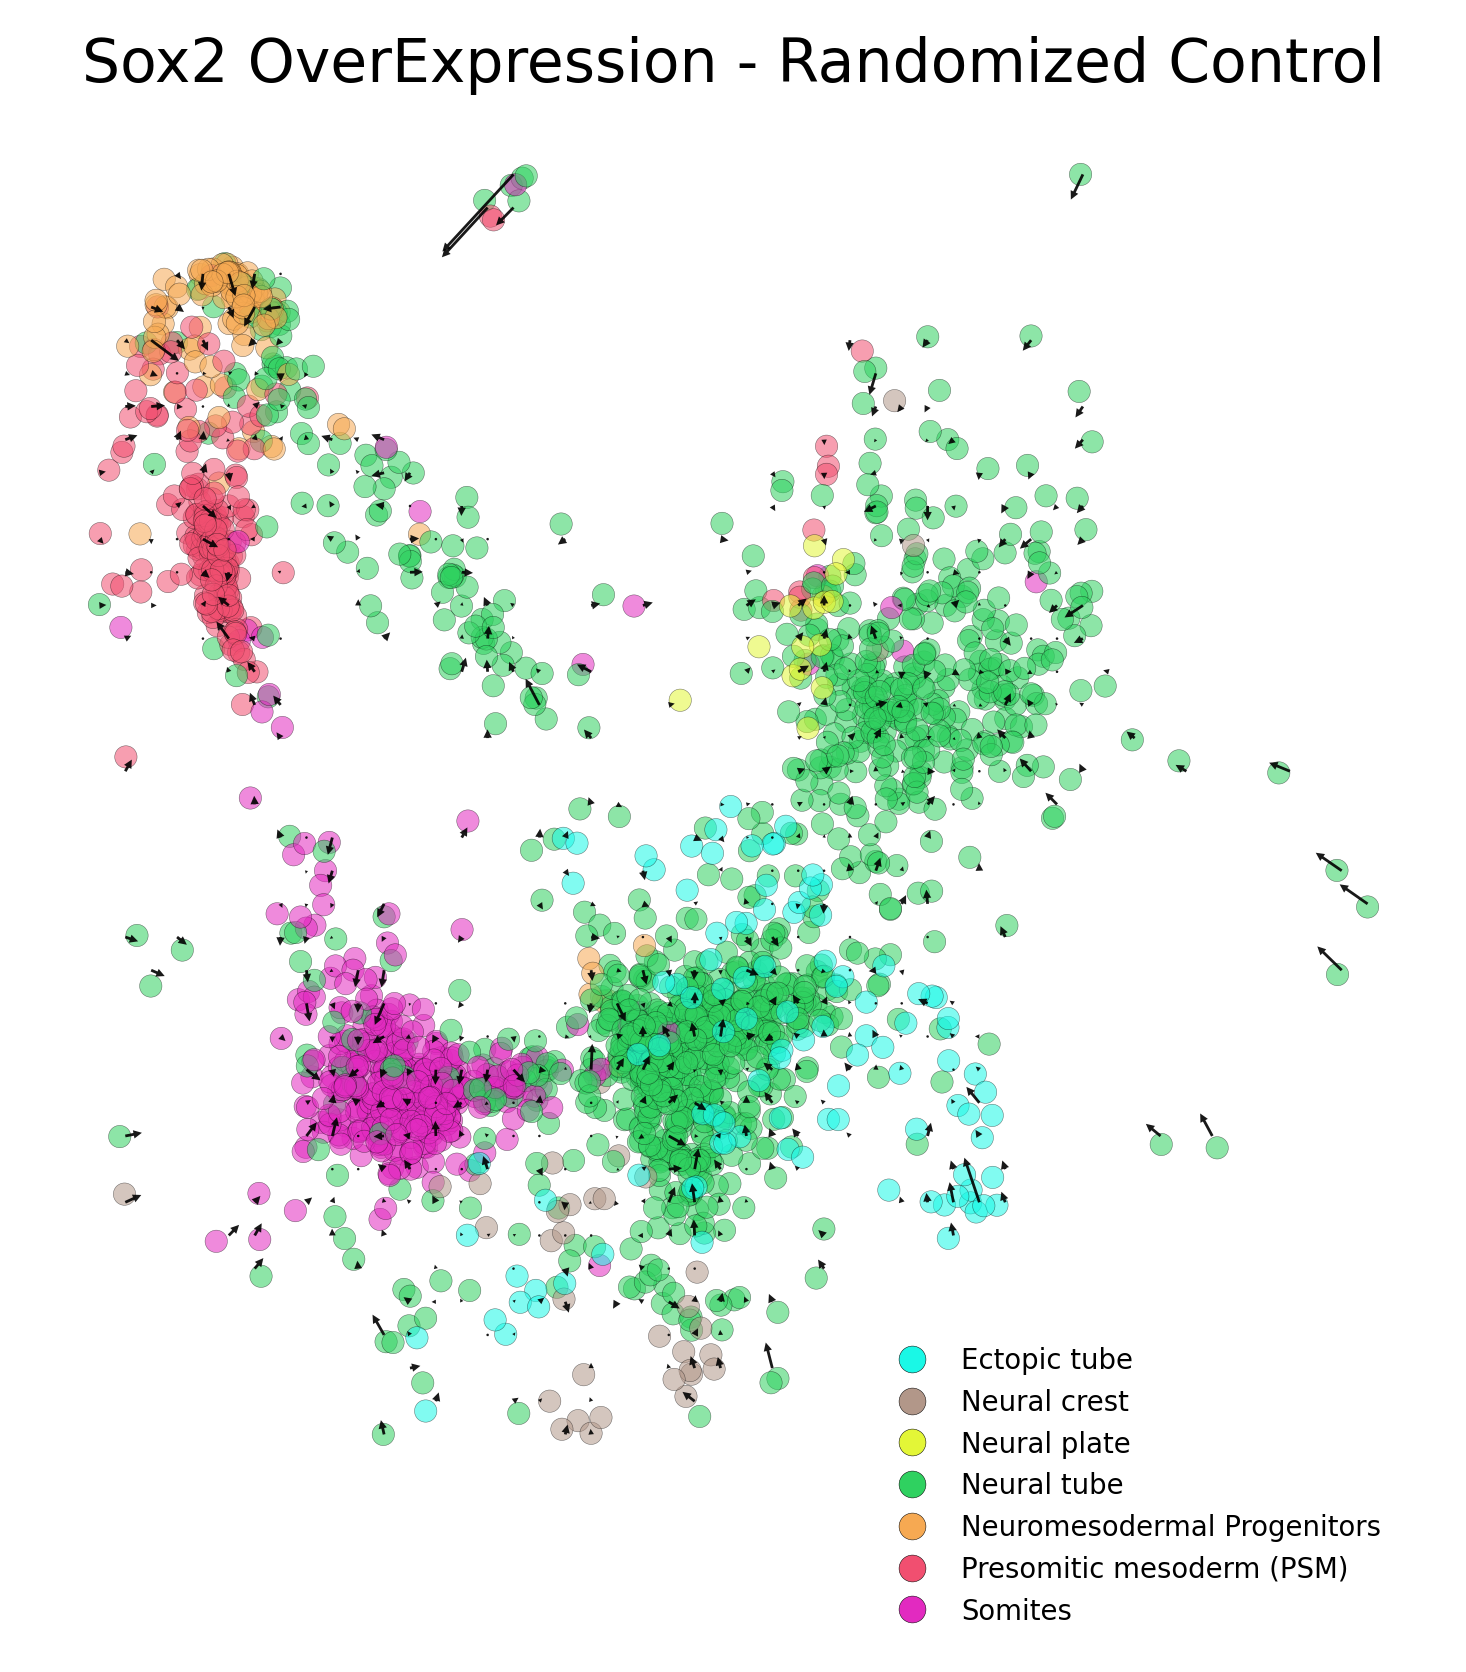

In [165]:
kotarget = 'Sox2'
ax = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=1,
    vector_scale=0.3,
    figsize=(5, 5), 
    hue='cell_type',
    alpha=0.55,
    n_neighbors=40,
    scatter_size=20,
    legend_on_loc=False,
    remove_null=False,
    normalize=False,
    perturbed_df=dfko.loc[chart.adata.obs_names].sample(axis=1, frac=1.0),
    legend_fontsize=2.5
)

leg = plt.legend(bbox_to_anchor=(0.6, -0.1), loc='lower left', 
    borderaxespad=0., markerscale=1.2, 
    fontsize=5.5, frameon=False, ncols=1)

for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.title(f'{kotarget} OverExpression - Randomized Control')
plt.show()

In [166]:
from spaceoracle.plotting.shift import estimate_transition_probabilities
kotarget = 'Sox2'
embedding = chart.adata.obsm['X_umap']
chart.unperturbed_expression = chart.unperturbed_expression.loc[chart.adata.obs_names]
n_neighbors = 2000
# betadata_path = '/Users/koush/Downloads'
# perturbed_df = pd.read_parquet(
#     f'{betadata_path}/{kotarget}_4n_0x.parquet')
perturbed_df=dfko.loc[chart.adata.obs_names]
delta_X = perturbed_df.loc[
    chart.adata.obs_names].values - chart.adata.layers['imputed_count']
chart.adata.layers[kotarget] = perturbed_df.loc[chart.adata.obs_names].values.copy()
corr = chart.get_corr(kotarget)
P = estimate_transition_probabilities(
    chart.adata, delta_X, embedding, n_neighbors=n_neighbors, n_jobs=1)
del chart.adata.layers[kotarget]

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_33519/1365882428.py:12: ImplicitModificationWarning: Setting element `.layers['Sox2']` of view, initializing view as actual.
  chart.adata.layers[kotarget] = perturbed_df.loc[chart.adata.obs_names].values.copy()


In [169]:
source_ct = 'Somites'
transition_df = chart.compute_transitions(corr, source_ct=source_ct)
chart.assess_transitions(
    transition_df, 
    base_celltypes=chart.adata.obs.cell_type, 
    source_ct=source_ct,
    annot='cell_type'
)

thresh = 0.0005 # need to cross this to leave base cell phenotype
allowed_fates = [
    'Neural tube',
    # 'Central tube',
    'Ectopic tube',
    'Somites',
    # 'Neuromesodermal Progenitors ',
    # 'Presomitic mesoderm (PSM)'
]

print(source_ct)
transitions = chart.get_cellfate(transition_df, allowed_fates, thresh)

Somites
Counter({'Neural tube': 302, 'Somites': 81, 'Ectopic tube': 1}) 0.0007337806471137628


In [170]:
source_ct = 'Neural tube'
transition_df = chart.compute_transitions(corr, source_ct=source_ct)
chart.assess_transitions(
    transition_df, 
    base_celltypes=chart.adata.obs.cell_type, 
    source_ct=source_ct,
    annot='cell_type'
)

thresh = 0.0005 # need to cross this to leave base cell phenotype
allowed_fates = [
    'Neural tube',
    # 'Central tube',
    'Ectopic tube',
    'Somites',
    # 'Neuromesodermal Progenitors ',
    # 'Presomitic mesoderm (PSM)'
]

print(source_ct)
transitions = chart.get_cellfate(transition_df, allowed_fates, thresh)

Neural tube
Counter({'Neural tube': 1029, 'Somites': 220}) 0.0006635966746431192


In [24]:
adata.obs.cell_type.value_counts()

cell_type
Neural tube                     1303
Mesenchyme                      1198
Brain                           1182
Pharyngeal arch                  817
Secondary heart field (SHF)      714
Preplacodal ectoderm             402
Somites                          390
Presomitic mesoderm (PSM)        218
Neuromesodermal Progenitors      113
Angioblasts                       91
Amnion mesoderm early             53
Neural crest                      43
Amnion mesoderm late              34
Heart                              1
Name: count, dtype: int64

In [178]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')
adata.X = adata.layers['imputed_count'].copy()
coko = pd.read_parquet('/Users/koush/Downloads/simulated_count.parquet').loc[adata.obs_names]
dfko = pd.read_parquet('/Users/koush/Downloads/Tbx6_4n_0x.parquet')

In [29]:
wtko = sc.read_h5ad('/Users/koush/Downloads/mouse_trunkTbx6WT_KO.h5ad')
wtko.var_names = wtko.var['feature_name']
wt = wtko[wtko.obs['orig.ident'] == '200703_25']
ko = wtko[wtko.obs['orig.ident'] == '200808_21']
del wt.raw
del ko.raw
wt.obsm['X_umap'] = wt.obs[['umap_1', 'umap_2']].values
ko.obsm['X_umap'] = ko.obs[['umap_1', 'umap_2']].values

shared = np.intersect1d(wt.var_names, dfko.columns)

/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Erg28', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', 'Dele1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [30]:
adata = adata[dfko.index]

In [85]:
mask = adata[adata.obs.cell_type.isin(['Somites', 'Neural tube'])].obs.index
a = (wt[:, wt.var_names.isin(shared)].to_df()[shared].mean() - ko[
    :, ko.var_names.isin(shared)].to_df()[shared].mean()).sort_values(
    ascending=False, key=abs)
b = (adata.to_df(layer='imputed_count')[shared].loc[mask].mean()-dfko[shared].loc[mask].mean()).sort_values(
ascending=False, key=abs)
c = (adata.to_df(layer='imputed_count')[shared].loc[mask].mean()-coko[shared].loc[mask].mean()).sort_values(
ascending=False, key=abs)
diff = pd.concat([a, b, c], axis=1)
diff.columns = ['gt', 'sim', 'co']

In [82]:
from scipy.stats import pearsonr

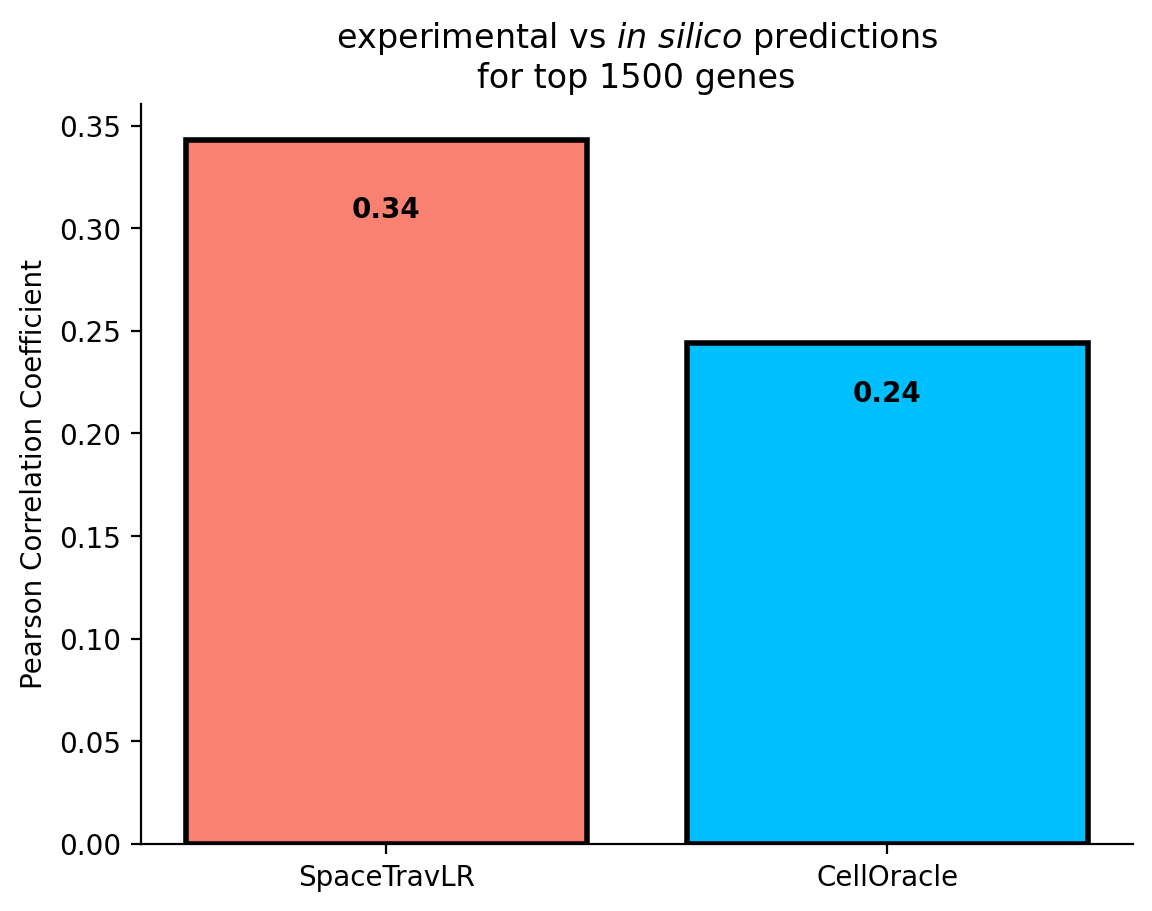

In [138]:
import matplotlib.pyplot as plt

N = 1500
genes = diff['gt'].head(N).index
gt_sim_corr = pearsonr(diff['gt'].loc[genes], diff['sim'].loc[genes]).statistic
gt_co_corr = pearsonr(diff['gt'].loc[genes], diff['co'].loc[genes]).statistic
gt_rand = pearsonr(
    diff['gt'], np.random.uniform(diff['gt'].min(), 
    diff['gt'].max(), size=diff['gt'].shape[0])).statistic


correlations = {'SpaceTravLR': gt_sim_corr, 'CellOracle': gt_co_corr}
plt.bar(correlations.keys(), correlations.values(), linewidth=2, 
    edgecolor='black', color=['salmon', 'deepskyblue', 'grey'])
plt.ylabel('Pearson Correlation Coefficient')
percentage_difference = ((gt_sim_corr - gt_co_corr) / gt_co_corr) * 100
plt.title(r'experimental vs $\it{in\ silico}$ predictions' + f'\nfor top ' + str(N) + ' genes')

for i, (key, value) in enumerate(correlations.items()):
    plt.text(i, value * 0.9, f'{value:.2f}', ha='center', 
        va='center', color='black', fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [179]:
projection_params = {
    'basis': 'spatial',
    'color': 'cell_type', 
    'legend_loc': 'right',
    'recompute': True,
    'stream': False,
    'scale': 0.3,
    'alpha': 0.6,
    'size': 50,
    'show': False,
    'linewidth': 0.1,
    'palette': color_dict,
    'min_mass': 40,
    'smooth': 1,
    'edgecolor': 'none',
    'arrow_color':'black',
    'n_neighbors': 50,
}

Renamed 'spatial' to convention 'X_spatial' (adata.obsm).
will return


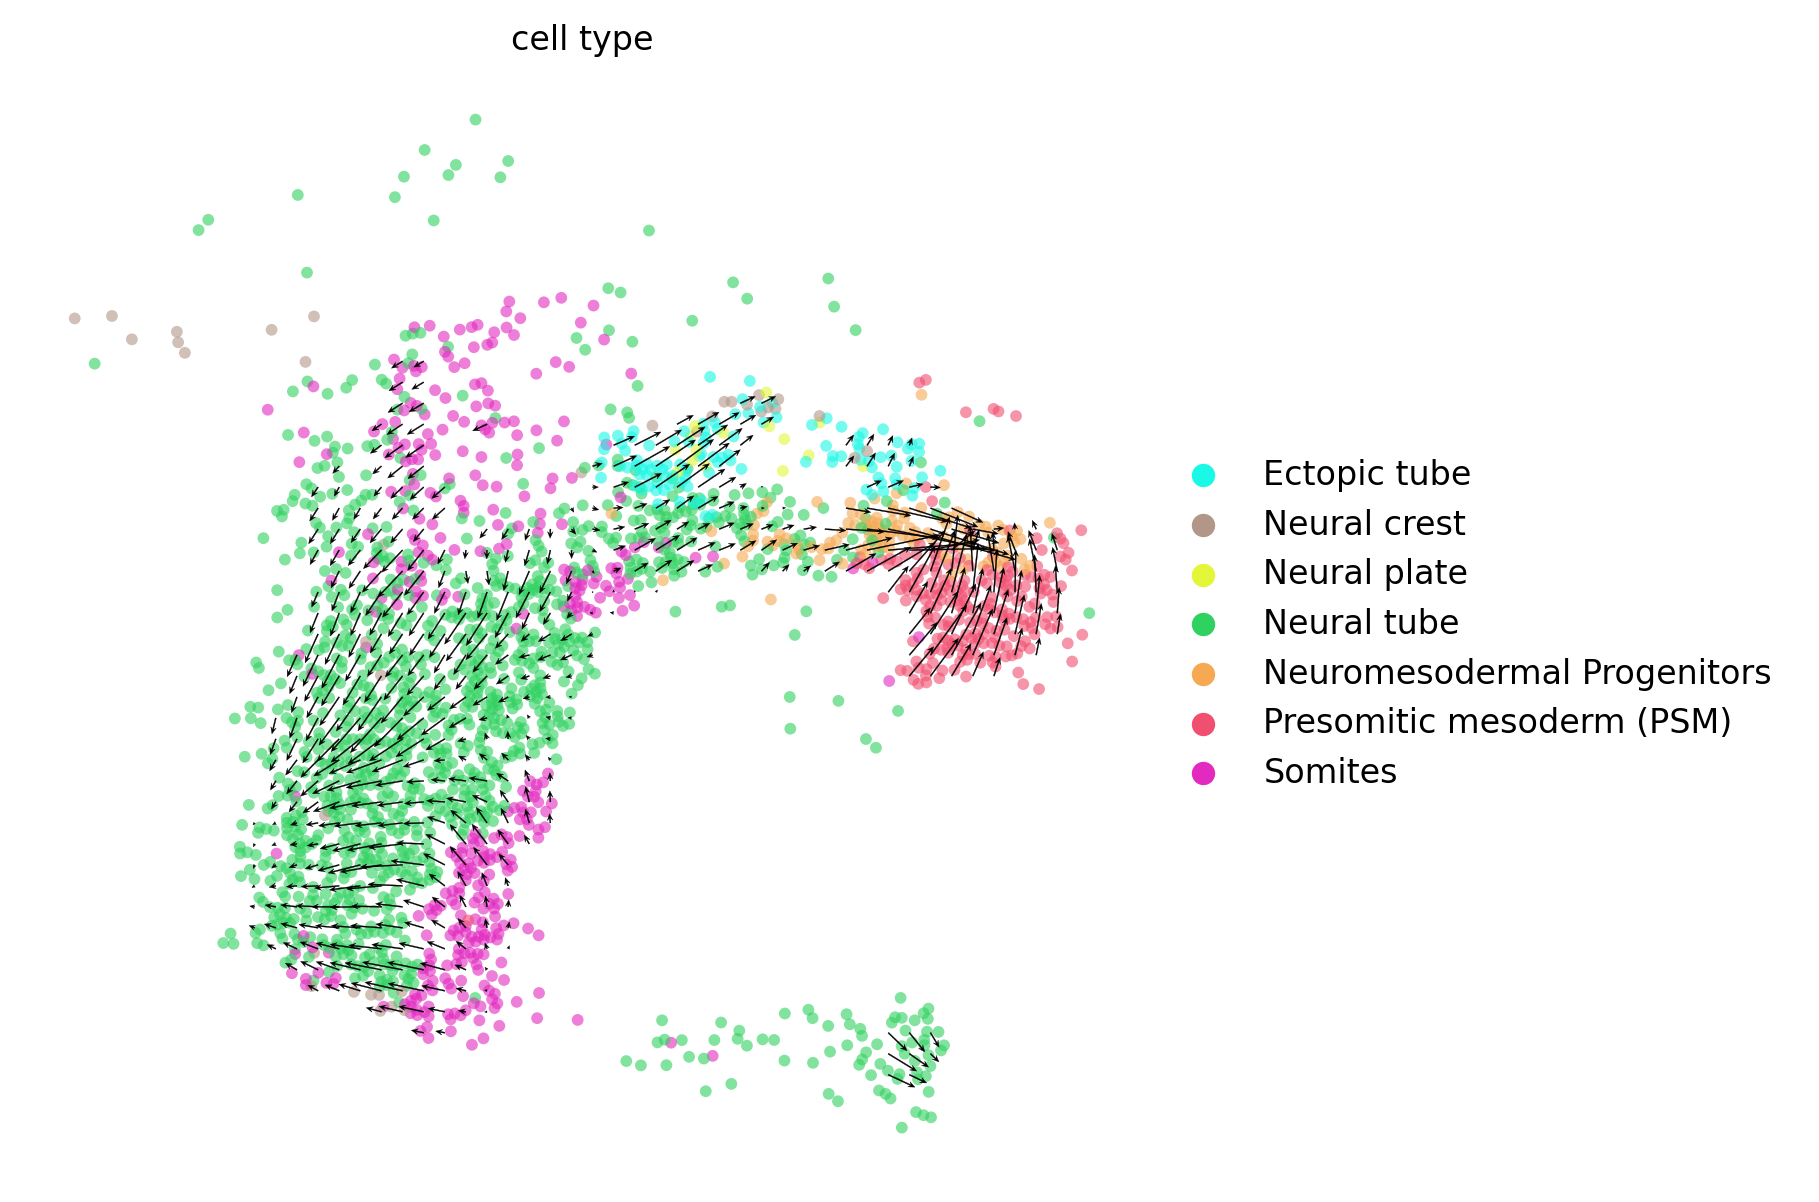

In [180]:
# %%capture
X_grid, V_grid = chart.get_grids(P, projection_params)
vector_field_ref = chart.vector_field_df(X_grid, V_grid)

In [765]:
import scanpy as sc
ref_adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')

In [772]:
adata.obs.cell_type.value_counts()

cell_type
Neural tube                     1303
Somites                          390
Presomitic mesoderm (PSM)        218
Neuromesodermal Progenitors      113
Ectopic tube                     108
Neural crest                      72
Neural plate                      15
Name: count, dtype: int64

In [776]:
vector_field_df = vector_field_ref.join(adata.obs.cell_type).query(
    'cell_type == "Somites"'
)

In [777]:
xy = xy_from_adata(ref_adata)

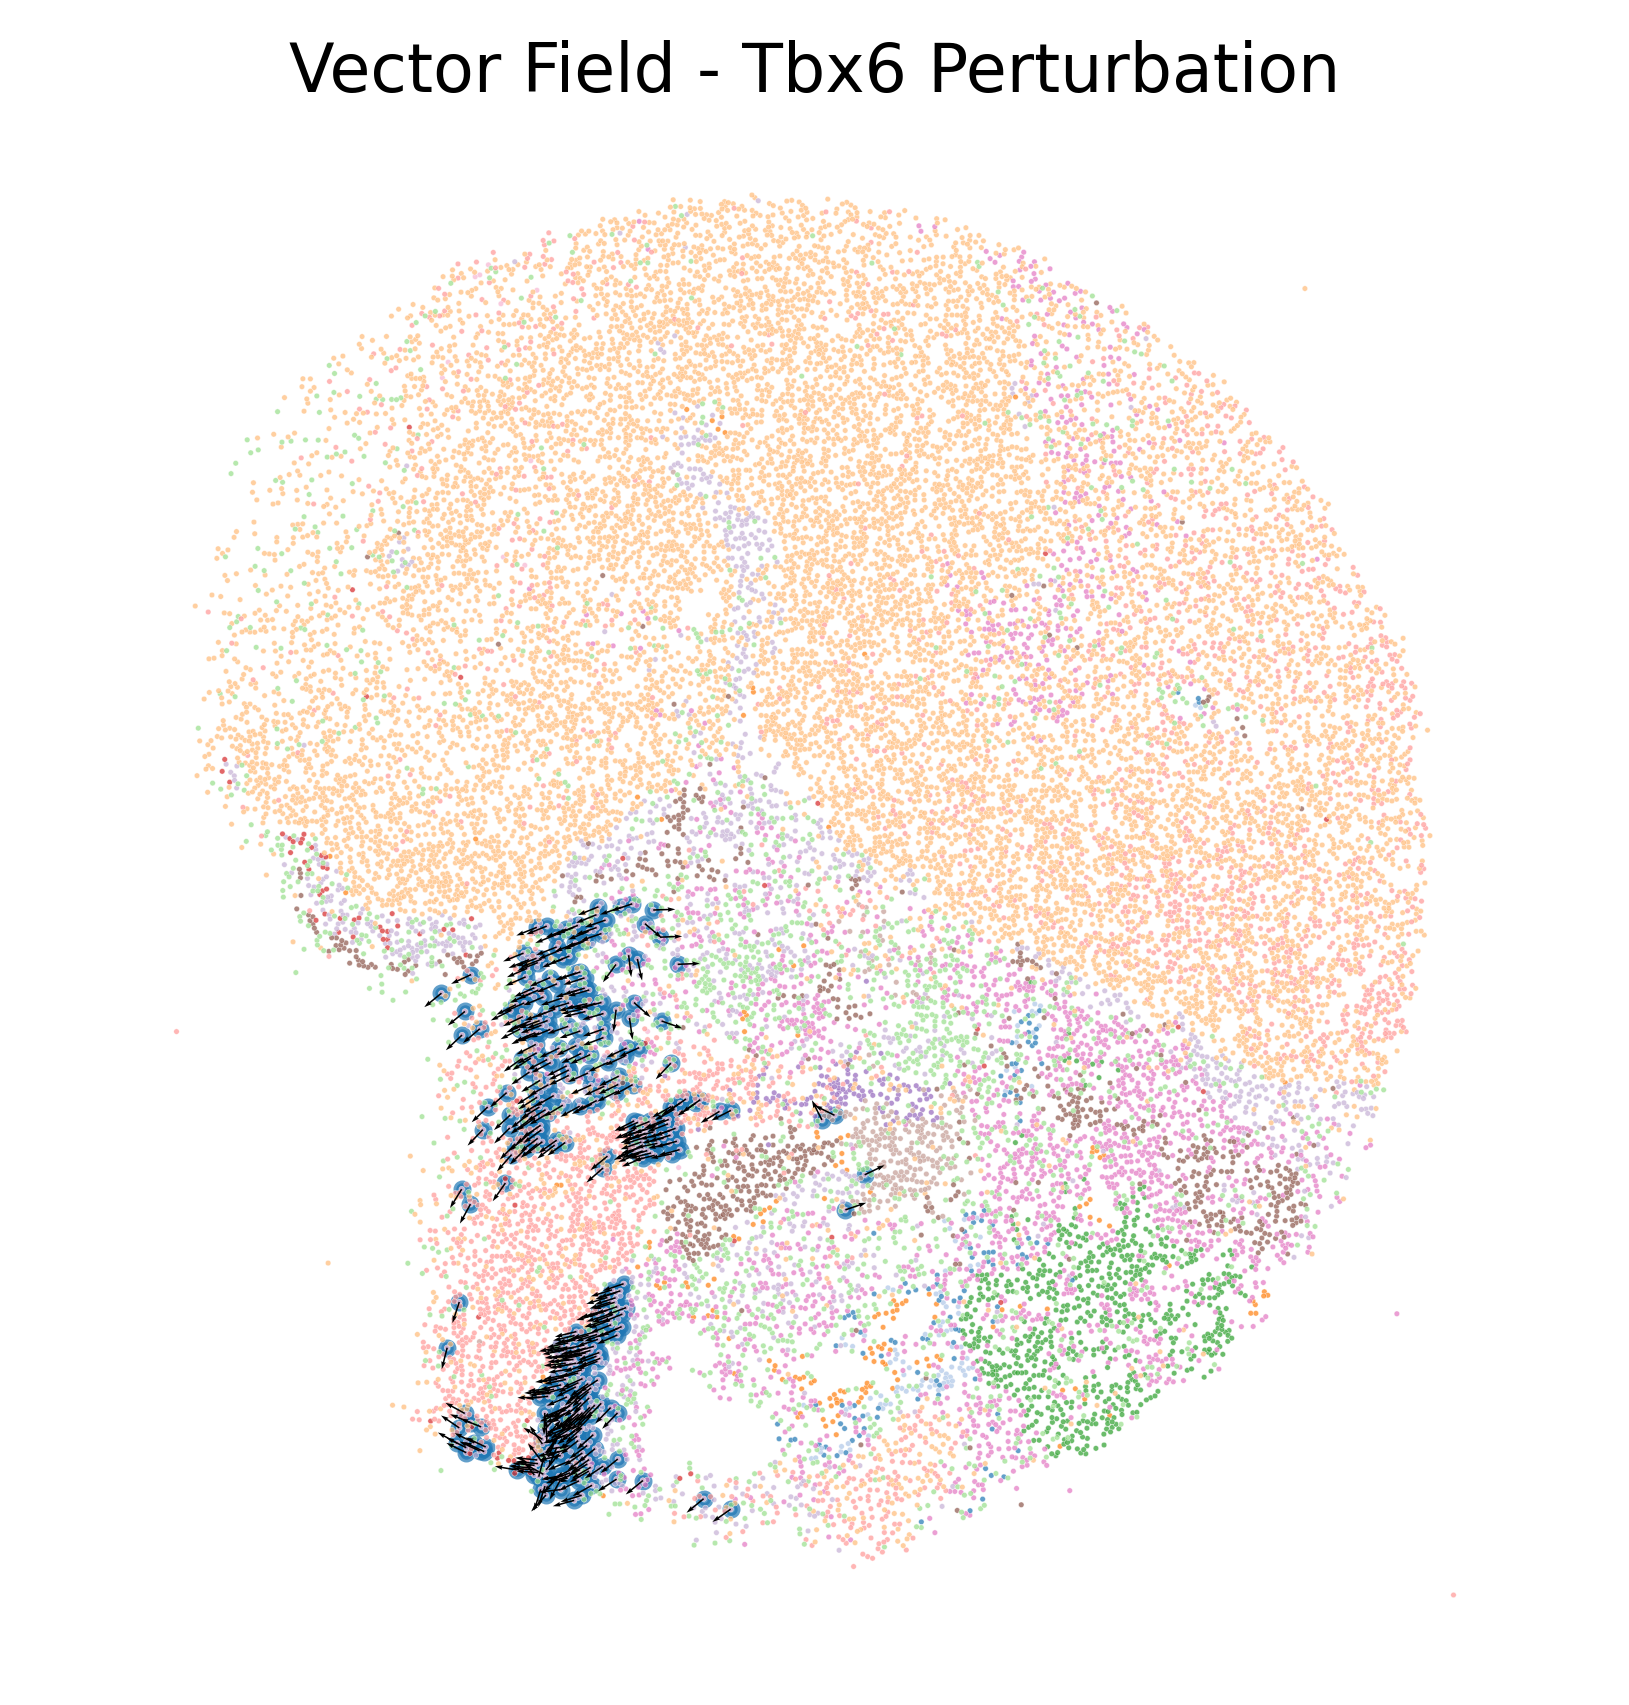

In [780]:
plt.figure(figsize=(5, 5), dpi=200)
ax = plt.gca()

# Plot cells colored by cell type
scc = plt.scatter(
    vector_field_df['x'], 
    vector_field_df['y'],
    s=5,
    alpha=0.7
)

sns.scatterplot(
    data=xy.join(ref_adata.obs.cell_type),
    x='x', 
    legend=False,
    y='y',
    palette='tab20',
    hue='cell_type',
    s=1,
    linewidth=0.1,
    alpha=0.7
)

# Convert angles to directional vectors
angles_rad = np.radians(vector_field_df['angle'])
u = np.cos(angles_rad)
v = np.sin(angles_rad)

# Plot the vector field with quiver
quiver = plt.quiver(
    vector_field_df['x'], 
    vector_field_df['y'],
    u, v,
    color='black',
    scale=70,
    width=0.001
)

plt.axis('equal')
plt.axis('off')
plt.title(f'Vector Field - {kotarget} Perturbation')
plt.show()

<Axes: xlabel='x', ylabel='y'>

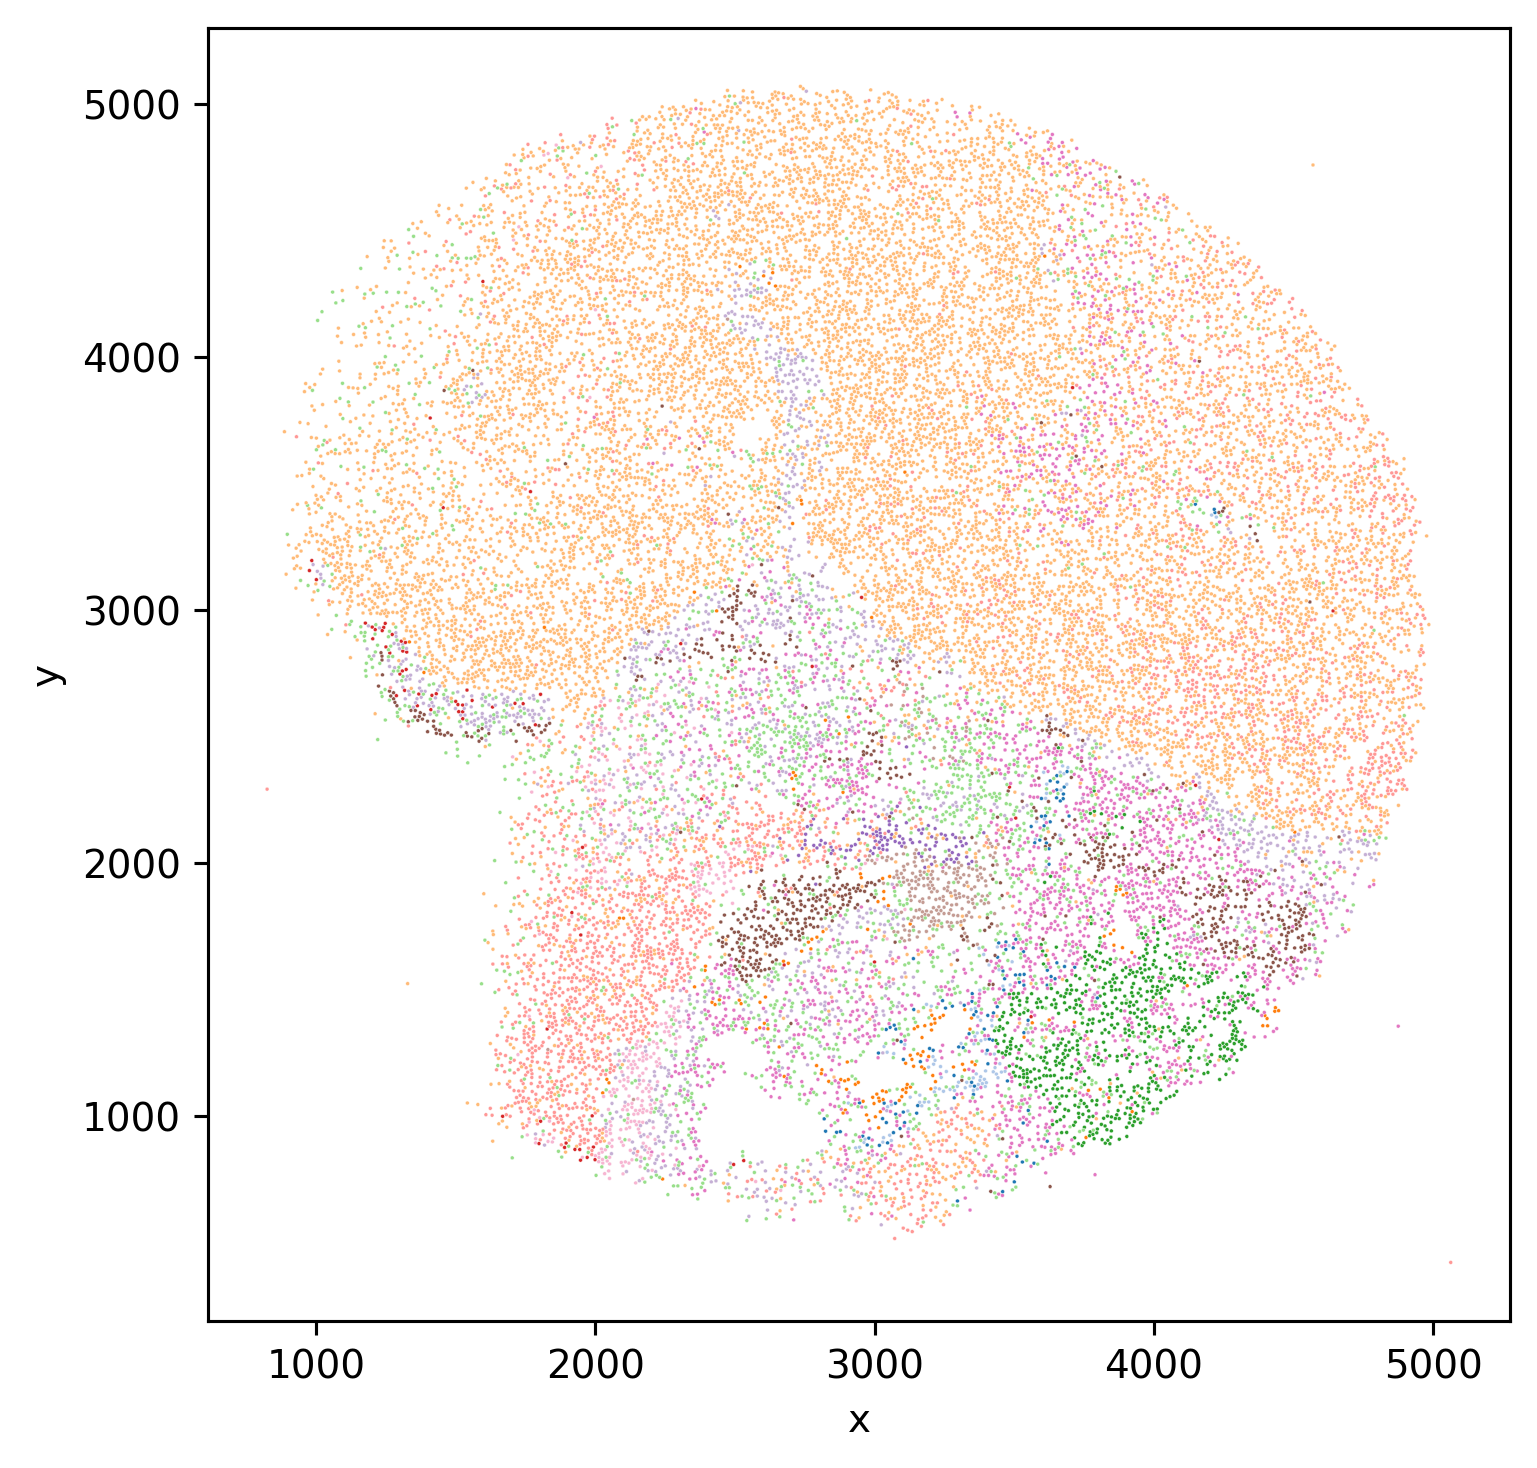

In [783]:
sns.scatterplot(
    data=xy.join(ref_adata.obs.cell_type),
    x='x', 
    legend=False,
    y='y',
    palette='tab20',
    hue='cell_type',
    s=1,
    linewidth=0.1,
    alpha=1
)


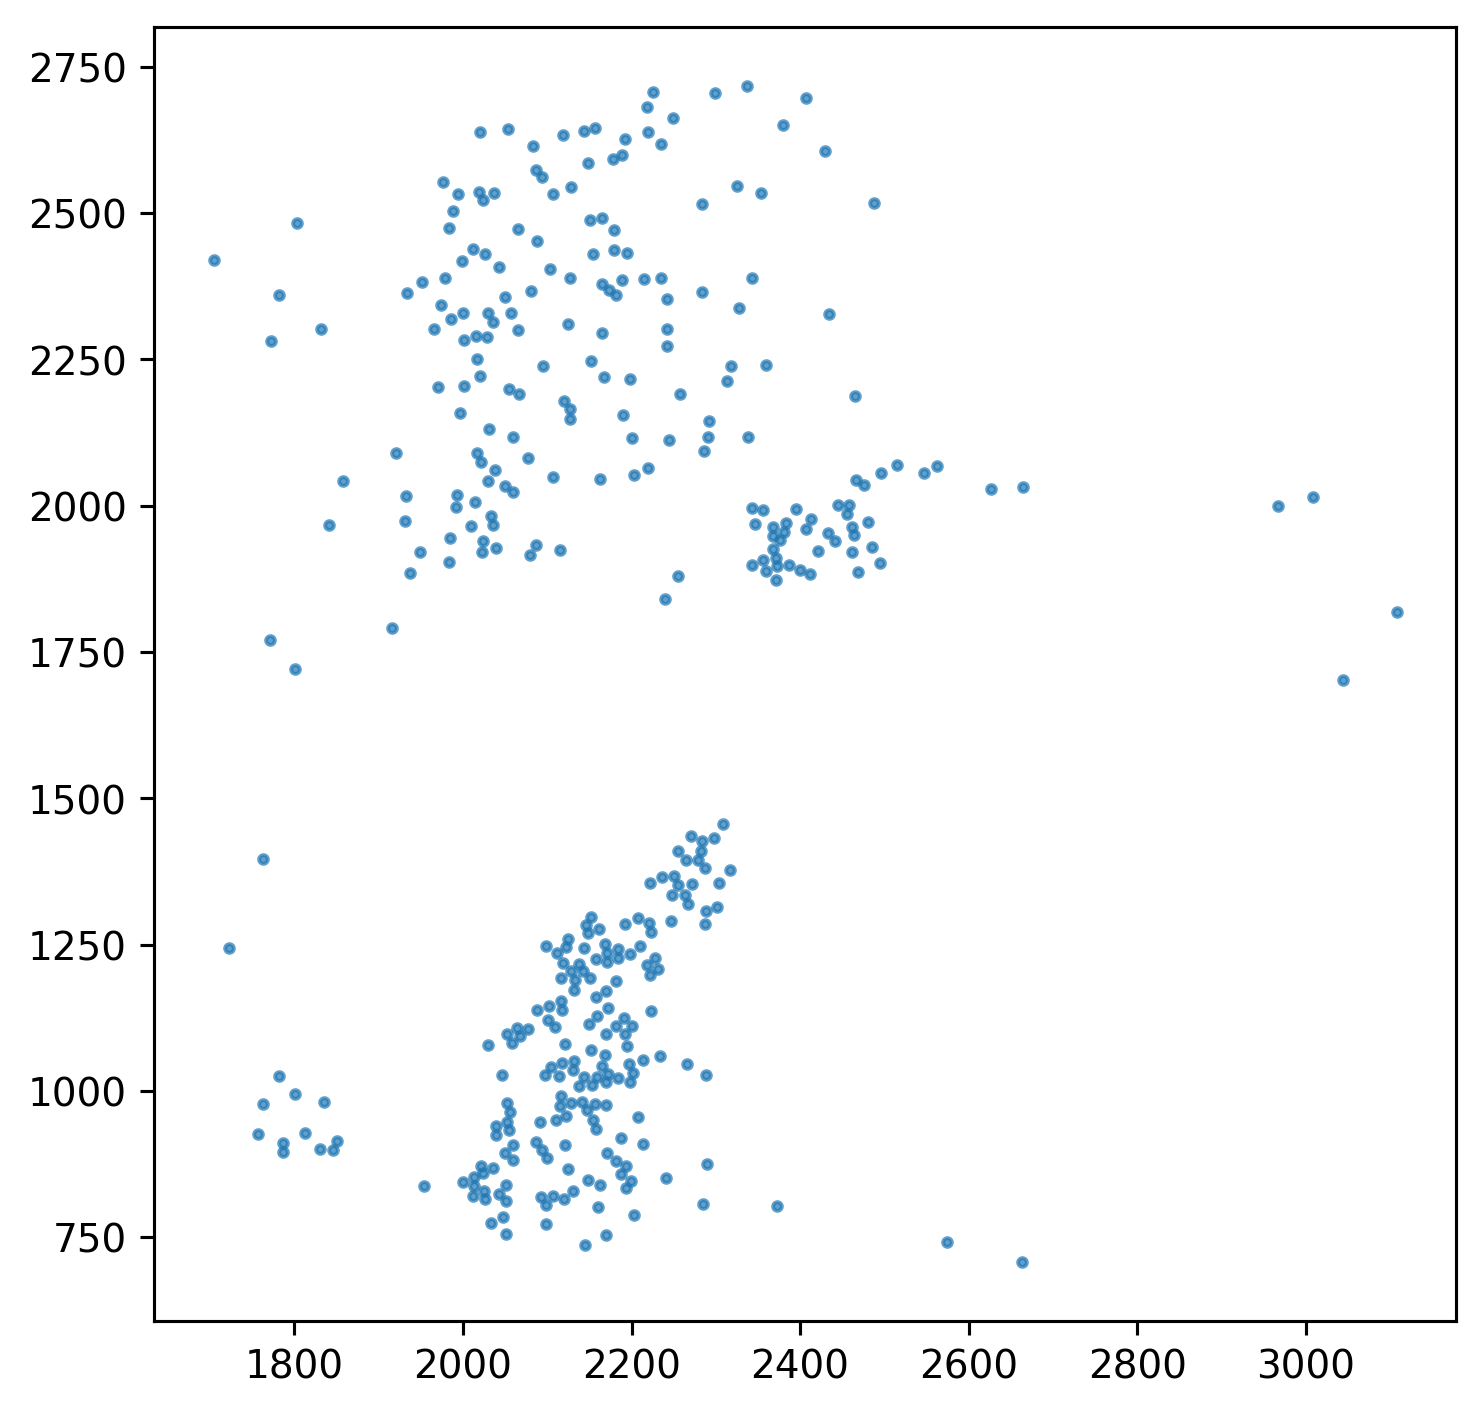

In [781]:
scc = plt.scatter(
    vector_field_df['x'], 
    vector_field_df['y'],
    s=5,
    alpha=0.7
)

In [331]:
source_cells = adata.obs[adata.obs['cell_type'] == source_ct].index

In [332]:
adata.obs['transition'] = adata.obs['cell_type'].copy()
adata.obs.loc[source_cells, 'transition'] = np.array(transitions)
ct_points_wt, ct_points_ko = chart.make_celltype_dict()

In [335]:
delta_df = perturbed_df.loc[chart.adata.obs_names] - chart.adata.layers['imputed_count']

KeyError: "None of [Index(['201112_04_TCACATAATTCAAG', '201112_04_ACTCGGTTCCTTCT',\n       '201112_04_GTCCTTAACTTCTA', '201112_04_CTTGCTAGGGTATA',\n       '201112_04_TATCCACGTCCGTG', '201112_04_GGCTTCCACCTCTG',\n       '201112_04_ACCAGGAACGTAGC', '201112_04_AATCACCGACTGGC',\n       '201112_04_GACCATCGGGCACT', '201112_04_AATTTACCTTAAGC',\n       ...\n       '201112_04_GGAATAAGCTTGGT', '201112_04_TGGTAAGAGGATCA',\n       '201112_04_CACTAGAAAACGGT', '201112_04_ATACCGGGACAAGG',\n       '201112_04_TAATACGTCTAGTC', '201112_04_GGCCTAACTAGCTT',\n       '201112_04_AAAATGGTGTGCAG', '201112_04_AATTAAGCCCACAG',\n       '201112_04_ATCCGGGTTCAGAG', '201112_04_ATTCGATTACCGGC'],\n      dtype='object', length=390)] are in the [index]"

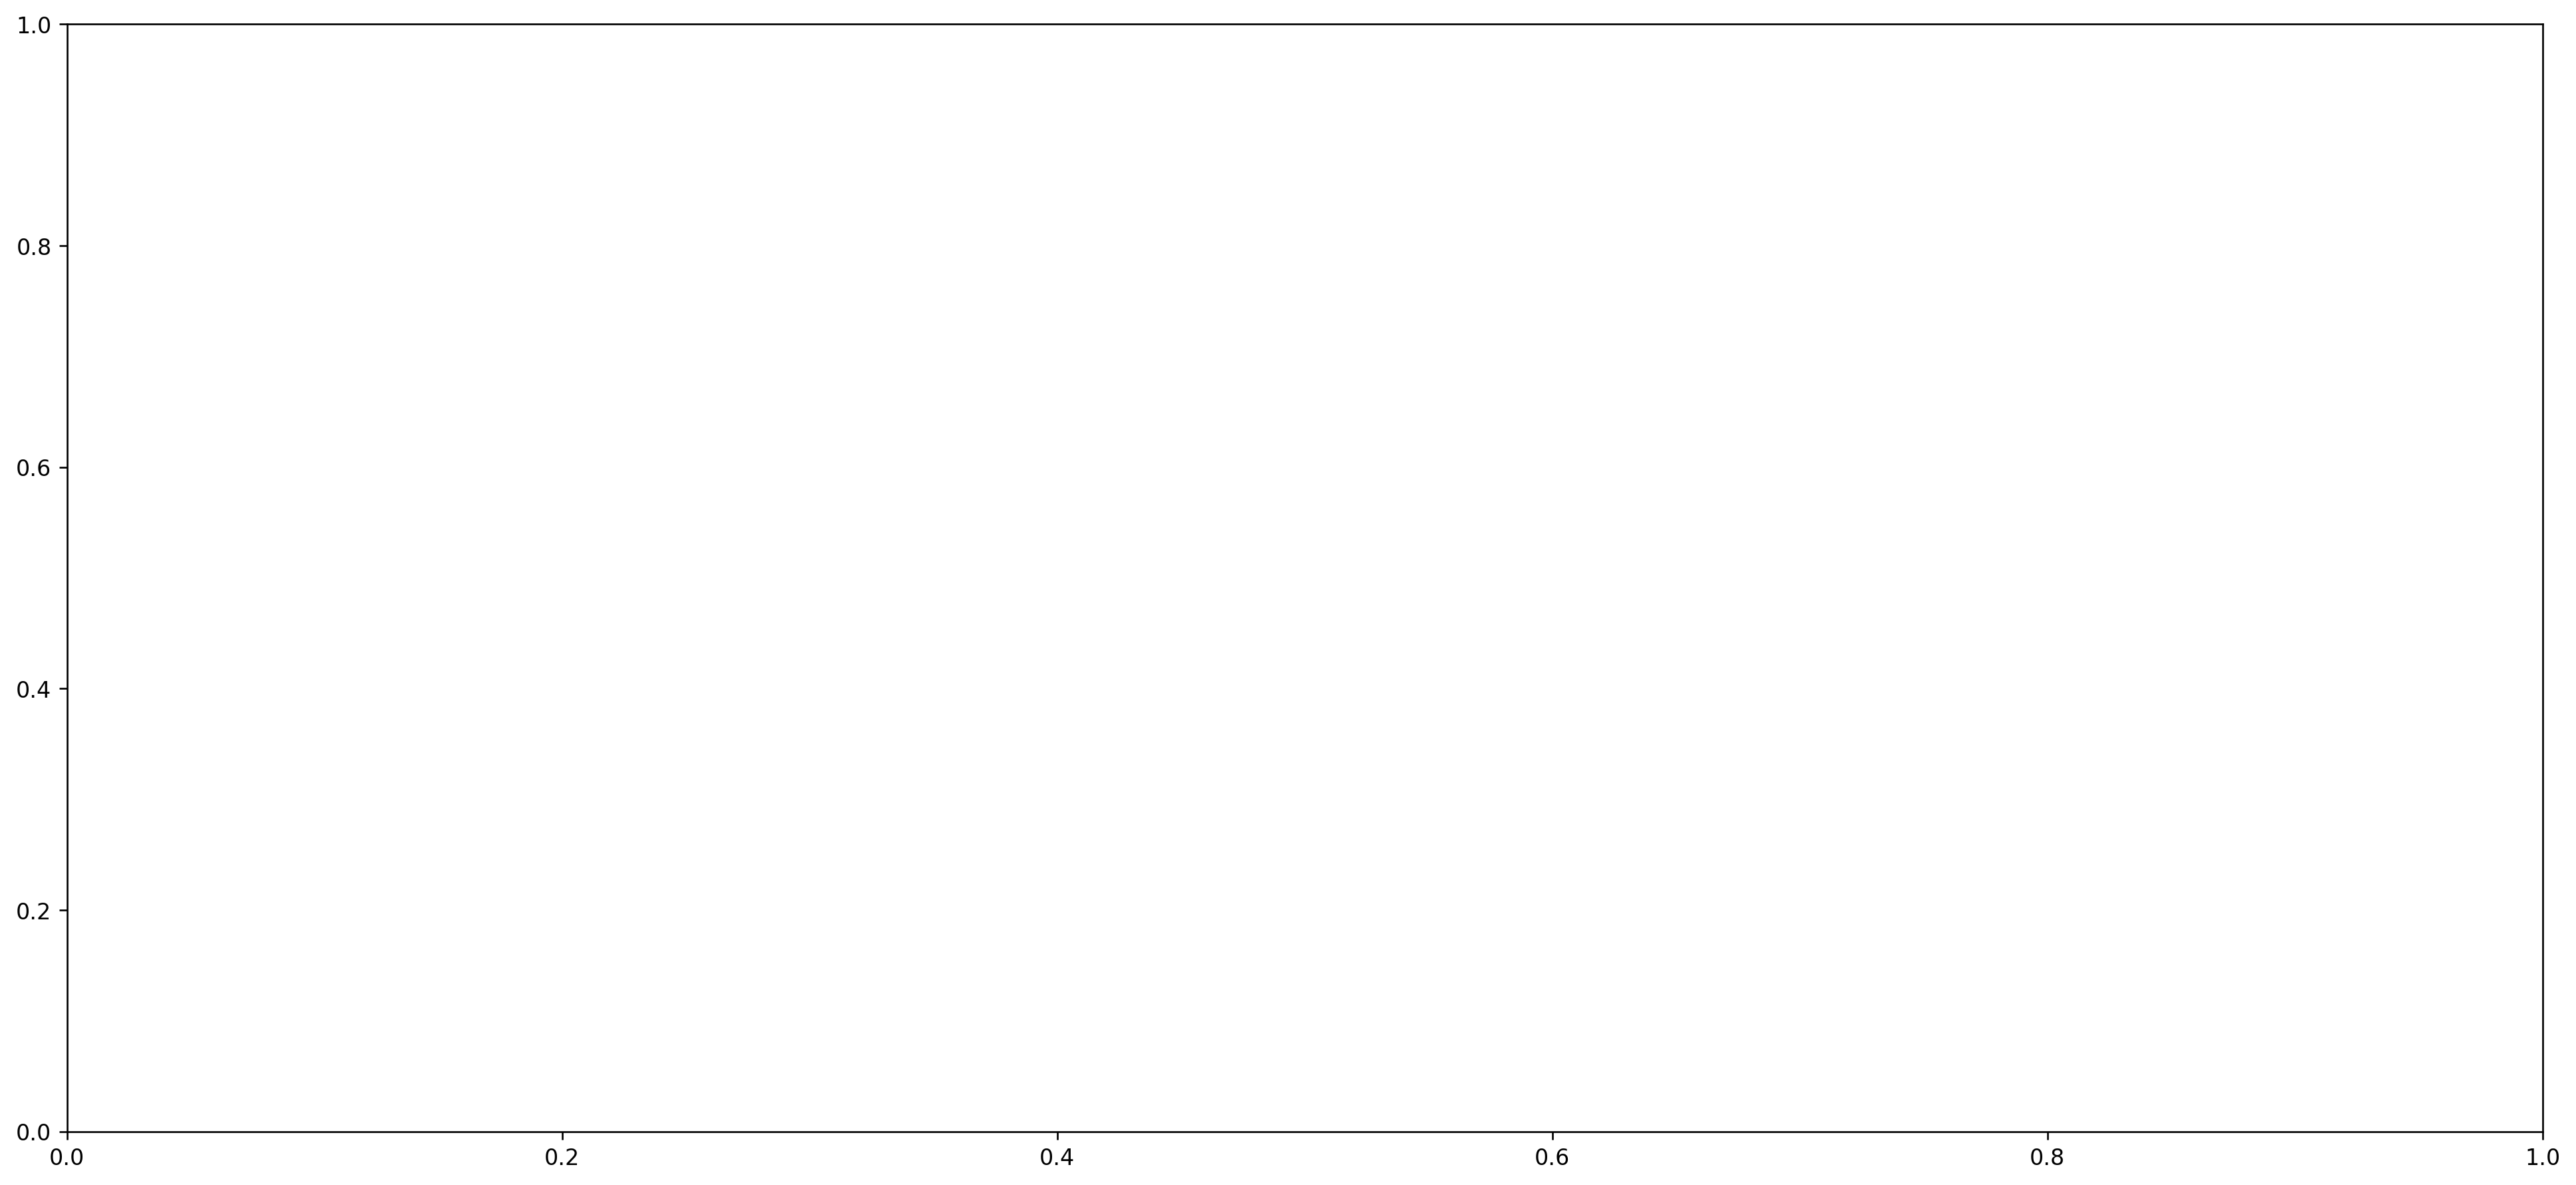

In [337]:
from matplotlib.legend_handler import HandlerTuple
import matplotlib
# Custom handler for wedge pairs in legend
class WedgePairHandler:
    def __init__(self, rotation=0):
        self.rotation = rotation
        
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        r = min(width, height) * 1
        center = (x0 + width/2, y0 + height/2)
        
        # Create left and right wedges with rotation
        wedge1 = matplotlib.patches.Wedge(
            center=center,
            r=r,
            theta1=90 + self.rotation, theta2=270 + self.rotation,
            facecolor=orig_handle[0].get_facecolor(),
            edgecolor='black',
            linewidth=0.25,
            transform=handlebox.get_transform()
        )
        
        wedge2 = matplotlib.patches.Wedge(
            center=center,
            r=r,
            theta1=-90 + self.rotation, theta2=90 + self.rotation,
            facecolor=orig_handle[1].get_facecolor(),
            edgecolor='black', 
            linewidth=0.25,
            transform=handlebox.get_transform()
        )
        
        handlebox.add_artist(wedge1)
        handlebox.add_artist(wedge2)
        return [wedge1, wedge2]

fig, ax = plt.subplots(figsize=(20, 9), dpi=120)
data = xy.join(adata.obs)
source_data = data[data.cell_type == source_ct]
transition_data = data.loc[source_cells]

scatter = sns.scatterplot(
    data=xy.join(adata.obs),
    x='x', y='y',
    # hue='banksy_celltypes', 
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    # palette=color_dict,
    ax=ax,
)

    
radius = 18

angles = vector_field_df.angle

for idx, row in data.iterrows():
    if idx in source_cells:
        angle = angles[idx]
        circle1 = matplotlib.patches.Wedge((row.x, row.y), radius, 90+angle, 270+angle,
                                         facecolor=color_dict[row.cell_type],
                                         alpha=1,
                                         edgecolor='black', linewidth=0.25)
        circle2 = matplotlib.patches.Wedge((row.x, row.y), radius, -90+angle, 90+angle,
                                         facecolor=color_dict[row.transition],
                                         alpha=1,
                                         edgecolor='black', linewidth=0.25)
        ax.add_patch(circle1)
        ax.add_patch(circle2)
    else:
        continue
        circle = plt.Circle((row.x, row.y), radius=radius//1.5,
                          facecolor='grey',
                          alpha=0.5,
                          edgecolor='none') 
        ax.add_patch(circle)
# for ii, jj in edges:
#     ax.plot(
#         points[[ii, jj], 0], 
#         points[[ii, jj], 1], 'k', 
#         linewidth=1, alpha=0.65, 
#         linestyle='--', color='red')

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
ax.set_ylim(data.y.min() - 10, data.y.max() + 10)

# Collect all unique transition types from transition_data
unique_transitions = transition_data['transition'].unique()

# Create legend elements for each transition type
legend_elements = []
labels = []

# Create legend elements with fixed angles for consistent appearance
for transition in unique_transitions:
    # Count number of transitions for this type
    n_transitions = len(transition_data[transition_data['transition'] == transition])
    
    wedge_source = matplotlib.patches.Wedge((0,0), radius, 0, 0,
                                          facecolor=color_dict[source_ct])
    wedge_transition = matplotlib.patches.Wedge((0,0), radius, 0, 0,
                                              facecolor=color_dict[transition])
    legend_elements.append((wedge_source, wedge_transition))
    labels.append(f"{source_ct} → {transition} (n={n_transitions})")

# Create the transitions legend using custom handler with 45 degree rotation
transition_legend = ax.legend(legend_elements, labels, 
                            handler_map={tuple: WedgePairHandler(rotation=0)},
                            bbox_to_anchor=(1, 0.8), 
                            # loc='center right', 
                            borderaxespad=0.,
                            fontsize=15,
                            markerscale=5,
                            labelspacing=3,
                            handletextpad=1.5, 
                            frameon=False,
                            title="")


# sns.scatterplot(
#     data=vector_field_df.join(adata.obs).query(
#         'cell_type == "B_germinal_center"'), 
#     x='x', y='y', s=50, 
#     hue='banksy_celltypes', palette=color_dict, legend=False, ax=ax)

vecdf = vector_field_df.join(adata.obs).query(
    'cell_type == "Somites"')

magn = np.sqrt(V_grid[:, 0]**2 + V_grid[:, 1]**2)

ax.quiver(vecdf['x'], vecdf['y'], 
          np.cos(np.radians(vecdf['angle'])), 
          np.sin(np.radians(vecdf['angle'])),
          scale=25, width=0.002, alpha=0.5)

# q = plt.quiver(X_grid[:, 0], X_grid[:, 1], V_grid[:, 0], V_grid[:, 1],
#             #    magnitudes, 
#                cmap='magma', 
#                linewidth=0.4,
#                scale=1000, width=0.0035, 
#                alpha=0.4, edgecolor=None)

plt.xlabel('')
plt.ylabel('')
plt.title('')

# plt.tight_layout()
# plt.savefig('/tmp/transition_figure.png', dpi=300, format='png')
plt.show()

# scatter_legend = ax.legend(
#     title="Cell Types", bbox_to_anchor=(1.5, -0.0), 
#     loc='lower right', markerscale=2)

# for lh in scatter_legend.legend_handles:
#     lh.set_alpha(1)
# ax.add_artist(scatter_legend)


In [212]:
# fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
# data = xy.join(adata.obs)
# source_data = data[data.banksy_celltypes == source_ct]
# transition_data = data.loc[source_cells]

# scatter = sns.scatterplot(
#     data=xy.join(adata.obs),
#     x='x', y='y',
#     # hue='banksy_celltypes', 
#     color='grey',
#     s=30,
#     alpha=0.3,
#     edgecolor='none',
#     # palette=color_dict,
#     ax=ax,
# )

# alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.04)
# alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.04)
# alpha_shape_3 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.04)

# zone_alpha = 0.85
# for geom in alpha_shape_1.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

# for geom in alpha_shape_2.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Dark Zone'], alpha=zone_alpha)

# for geom in alpha_shape_3.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

# alpha_shape_4 = alphashape.alphashape(
#     np.concatenate(
#         [ct_points_wt['GC Light Zone'], 
#          ct_points_wt['GC Intermediate Zone'], 
#          ct_points_wt['GC Dark Zone']]
#         ), alpha=0.03)

# for geom in alpha_shape_4.geoms:
#     if geom.area > 10000:
#         ax.plot(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color='black', alpha=zone_alpha)

# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_aspect('equal')
# ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
# ax.set_ylim(data.y.min() - 10, data.y.max() + 10)
# plt.show()